In [31]:
import graphlab

In [32]:
graphlab.canvas.set_target('ipynb')

In [33]:
#taps = graphlab.SFrame.read_csv("taps.csv", verbose=False)
taps = graphlab.SFrame.read_csv("wow/6shcnktccn86m96hmcbng29s6t_taps.csv", verbose=False)
taps['type'].show()
taps['when'].show()
taps[taps['type'] == "TOUCH"]['action'].show()
taps[taps['type'] == "SWIPE"]['action'].show()

In [34]:
features = [
    "n_accel",
    
    "accel_x_mean",
    "accel_x_median",
    "accel_x_var",
    "accel_x_skewness",
    "accel_x_kurtosis",
    "accel_x_diff",
    
    "accel_y_mean",
    "accel_y_median",
    "accel_y_skewness",
    "accel_y_kurtosis",
    "accel_y_var",
    "accel_y_diff",
    
    "accel_z_mean",
    "accel_z_var",   
    "accel_z_median",
    "accel_z_skewness",
    "accel_z_kurtosis",
    "accel_z_diff",
    
    "n_gyro",
    
    "gyro_x_mean",
    "gyro_x_median",
    "gyro_x_var",
    "gyro_x_skewness",
    "gyro_x_kurtosis",
    "gyro_x_diff",
    
    "gyro_y_mean",
    "gyro_y_median",
    "gyro_y_var",
    "gyro_y_skewness",
    "gyro_y_kurtosis",
    "gyro_y_diff",
    
    "gyro_z_mean",
    "gyro_z_median",
    "gyro_z_var",
    "gyro_z_skewness",
    "gyro_z_kurtosis",
    "gyro_z_diff",
    
] 



In [35]:
train, test = taps.random_split(0.8, seed=1)


In [36]:
not_noise_train = train[train['noise'] == 0]
not_noise_test = test[test['noise'] == 0]

noise_train = train[train['noise'] == 1]
noise_test = test[test['noise'] == 1]

In [37]:
train_touchs = not_noise_train[not_noise_train['type'] == "TOUCH"]
train_swipes = not_noise_train[not_noise_train['type'] == "SWIPE"]
test_touchs = not_noise_test[not_noise_test['type'] == "TOUCH"]
test_swipes = not_noise_test[not_noise_test['type'] == "SWIPE"]

# Let's focus on boosted trees.

In [38]:
k_fold = graphlab.cross_validation.KFold(graphlab.cross_validation.shuffle(train), 5)

In [39]:
def f1_score(model, data):
    return model.evaluate(data, metric='f1_score')['f1_score']

def accuracy(model, data):
    return model.evaluate(data, metric='accuracy')['accuracy']

def get_cross_val_score(k_fold, model_factory, model_params, metric_f):
    val_errors = []
    train_errors = []
    for train, valid in k_fold:
        m = model_factory(train, **model_params)
        val_errors.append(metric_f(m, valid))
        train_errors.append(metric_f(m, train))
    return sum(train_errors)/float(len(train_errors)), sum(val_errors)/float(len(val_errors))


def get_best_max_iterations(k_fold, max_iterations_a, model_factory, model_params, metric_f, plot=True):
    val_a = []
    train_a = []
    for max_iterations in max_iterations_a:
        model_params['max_iterations'] = max_iterations
        train_e, val_e = get_cross_val_score(k_fold, model_factory, model_params, metric_f)
        val_a.append(val_e)
        train_a.append(train_e)
        print "At iterations:", max_iterations, val_e, train_e
    if plot:
        %matplotlib inline

        import matplotlib
        import numpy as np
        import matplotlib.pyplot as plt

        plt.plot(max_iterations_a, val_a)
        plt.plot(max_iterations_a, train_a)
    if metric_f == f1_score or metric_f == accuracy:
        return max_iterations_a[val_a.index(max(val_a))], max(val_a)
    return max_iterations_a[val_a.index(min(val_a))], min(val_a)

def get_best_depth(k_fold, depths, model_factory, model_params, metric_f, plot=True):
    val_a = []
    train_a = []
    for depth in depths:
        model_params['max_depth'] = depth
        train_e, val_e = get_cross_val_score(k_fold, model_factory, model_params, metric_f)
        val_a.append(val_e)
        train_a.append(train_e)
        print "At depth:", depth, val_e, train_e
    if plot:
        %matplotlib inline

        import matplotlib
        import numpy as np
        import matplotlib.pyplot as plt

        plt.plot(depths, val_a)
        plt.plot(depths, train_a)
    if metric_f == f1_score or metric_f == accuracy:
        return depths[val_a.index(max(val_a))], max(val_a)
    return depths[val_a.index(min(val_a))], min(val_a)

At iterations: 5 0.645949708664 0.646209775965
At iterations: 10 0.652405896036 0.652870010951
At iterations: 20 0.655819494389 0.656997862732
At iterations: 40 0.657452113035 0.659289059844
At iterations: 80 0.661274046726 0.664205391632
At iterations: 160 0.671811749742 0.676561137452
At iterations: 320 0.677525849617 0.68361096906
At iterations: 640 0.68049412389 0.691004025426


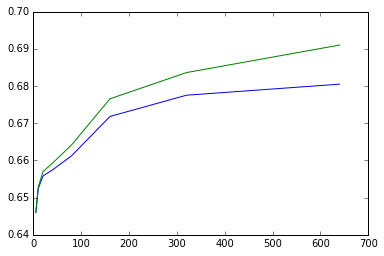

In [40]:
max_iterations_a = [5, 10, 20, 40, 80, 160, 320, 640]
model_params = dict([('target', 'noise'), ('features', features), ('verbose', False), ('validation_set', None),
                    ('max_depth', 1)])
model_factory = graphlab.boosted_trees_classifier.create
noise_max_iterations = get_best_max_iterations(k_fold, max_iterations_a, model_factory, model_params, accuracy)

At depth: 1 0.68049412389 0.691004025426
At depth: 2 0.748320987119 0.792326805623
At depth: 3 0.798412030771 0.886043196767
At depth: 4 0.836258245292 0.964704447725
At depth: 5 0.861934509829 0.997727354473
At depth: 6 0.879447791258 1.0
At depth: 7 0.889651473682 1.0
At depth: 8 0.89625608406 1.0
At depth: 9 0.901005455048 1.0


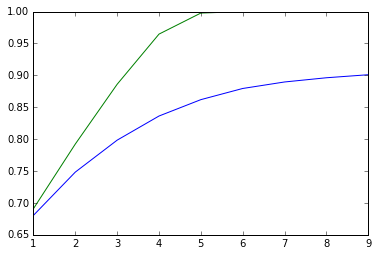

In [41]:
depths = range(1,10)
model_params['max_iterations'] = noise_max_iterations[0]
noise_max_depth = get_best_depth(k_fold, depths, model_factory, model_params, accuracy)

In [42]:
train_set_to_use = train
max_depth_to_use = noise_max_depth[0]
max_iterations_to_use = noise_max_iterations[0]

optimized_noise_classifier = graphlab.boosted_trees_classifier.create(train_set_to_use, target='noise', 
                                                                      features=features,
                                                                      max_depth=max_depth_to_use, 
                                                                      max_iterations=max_iterations_to_use,
                                                                      validation_set=None,
                                                                      verbose=False)

In [43]:
print optimized_noise_classifier.evaluate(test)

{'f1_score': 0.8765112262521589, 'auc': 0.9712234198443471, 'recall': 0.8248679398618448, 'precision': 0.9350529709811147, 'log_loss': 0.22170771877339696, 'roc_curve': Columns:
	threshold	float
	fpr	float
	tpr	float
	p	int
	n	int

Rows: 100001

Data:
+-----------+----------------+----------------+------+------+
| threshold |      fpr       |      tpr       |  p   |  n   |
+-----------+----------------+----------------+------+------+
|    0.0    |      1.0       |      1.0       | 2461 | 4305 |
|   1e-05   | 0.99512195122  | 0.999593661113 | 2461 | 4305 |
|   2e-05   | 0.98931475029  | 0.999593661113 | 2461 | 4305 |
|   3e-05   | 0.983042973287 | 0.999593661113 | 2461 | 4305 |
|   4e-05   | 0.97537746806  | 0.999593661113 | 2461 | 4305 |
|   5e-05   | 0.969105691057 | 0.999593661113 | 2461 | 4305 |
|   6e-05   | 0.963995354239 | 0.999593661113 | 2461 | 4305 |
|   7e-05   | 0.959349593496 | 0.999593661113 | 2461 | 4305 |
|   8e-05   | 0.955168408827 | 0.999593661113 | 2461 | 4305 |
|   

In [44]:
predicted_not_noise = test[optimized_noise_classifier.predict(test) == 0]

# Type classifier now

In [45]:
not_noise_k_fold = graphlab.cross_validation.KFold(graphlab.cross_validation.shuffle(not_noise_train), 5)

At iterations: 5 0.691813928298 0.69420912332
At iterations: 10 0.704200825953 0.705808793789
At iterations: 20 0.731315389261 0.737728571323
At iterations: 40 0.759130443097 0.7644189763
At iterations: 80 0.772278871928 0.779261442912
At iterations: 160 0.782212481899 0.790013491452
At iterations: 320 0.79255534594 0.801043073249
At iterations: 640 0.798281983208 0.80999826335


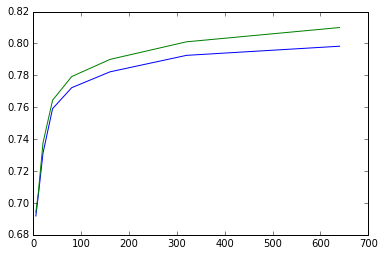

In [46]:
model_params = {'target': 'type', 'features': features, 'verbose': False, 'validation_set': None, 'max_depth': 1}
model_factory = graphlab.boosted_trees_classifier.create
type_max_iterations = get_best_max_iterations(not_noise_k_fold, max_iterations_a, model_factory, 
                                              model_params, accuracy)

At depth: 1 0.798281983208 0.80999826335
At depth: 2 0.852802329209 0.899886044796
At depth: 3 0.901478481336 0.981344569612
At depth: 4 0.925729034501 0.999897739842
At depth: 5 0.939227350035 1.0
At depth: 6 0.947641875968 1.0
At depth: 7 0.951206462011 1.0
At depth: 8 0.955413554234 1.0
At depth: 9 0.955822757081 1.0


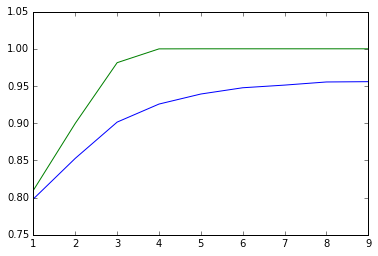

In [47]:
depths = range(1,10)

model_params['max_iterations'] = type_max_iterations[0]
type_max_depth = get_best_depth(not_noise_k_fold, depths, model_factory, model_params, accuracy)

In [48]:
train_set_to_use = not_noise_train
max_depth_to_use = type_max_depth[0]
max_iterations_to_use = type_max_iterations[0]

optimized_type_classifier = graphlab.boosted_trees_classifier.create(train_set_to_use, target='type', 
                                                                     features=features, max_depth=max_depth_to_use, 
                                                                     max_iterations=max_iterations_to_use,
                                                                     verbose=False, validation_set=None)

In [49]:
print optimized_type_classifier.evaluate(predicted_not_noise)

predicted_touches = predicted_not_noise[optimized_type_classifier.predict(predicted_not_noise) == "TOUCH"]
predicted_swipes = predicted_not_noise[optimized_type_classifier.predict(predicted_not_noise) == "SWIPE"]

{'f1_score': 0.6088754663965951, 'auc': 0.9933606594487073, 'recall': 0.6438406683616841, 'precision': 0.8670322790435172, 'log_loss': 3.3327132319436683, 'roc_curve': Columns:
	threshold	float
	fpr	float
	tpr	float
	p	int
	n	int

Rows: 100001

Data:
+-----------+----------------+-----+------+------+
| threshold |      fpr       | tpr |  p   |  n   |
+-----------+----------------+-----+------+------+
|    0.0    |      1.0       | 1.0 | 1541 | 2623 |
|   1e-05   | 0.794891345787 | 1.0 | 1541 | 2623 |
|   2e-05   | 0.735798703774 | 1.0 | 1541 | 2623 |
|   3e-05   | 0.697293175753 | 1.0 | 1541 | 2623 |
|   4e-05   | 0.667937476172 | 1.0 | 1541 | 2623 |
|   5e-05   | 0.641631719405 | 1.0 | 1541 | 2623 |
|   6e-05   | 0.625619519634 | 1.0 | 1541 | 2623 |
|   7e-05   | 0.608463591308 | 1.0 | 1541 | 2623 |
|   8e-05   | 0.593976362943 | 1.0 | 1541 | 2623 |
|   9e-05   | 0.577964163172 | 1.0 | 1541 | 2623 |
+-----------+----------------+-----+------+------+
[100001 rows x 5 columns]
Note: Onl

# Let's classify swipes

In [50]:
swipes_k_fold = graphlab.cross_validation.KFold(graphlab.cross_validation.shuffle(train_swipes), 5)

At iterations: 5 0.495988675504 0.497272064213
At iterations: 10 0.506527632815 0.510026179804
At iterations: 20 0.517906925164 0.524459024693
At iterations: 40 0.536094179452 0.543601858528
At iterations: 80 0.55325444456 0.561951977659
At iterations: 160 0.570135119855 0.585734835037
At iterations: 320 0.589534277911 0.611826104902
At iterations: 640 0.609866532721 0.639712662327


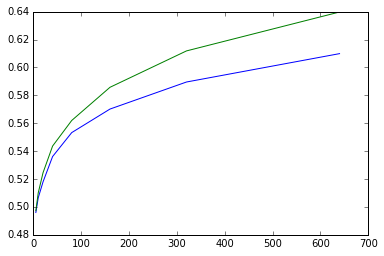

In [51]:
model_params = {'target': 'action', 'features': features, 'verbose': False, 'validation_set': None, 'max_depth': 1}
model_factory = graphlab.boosted_trees_classifier.create
swipe_max_iterations = get_best_max_iterations(swipes_k_fold, max_iterations_a, model_factory, model_params, accuracy)

At depth: 1 0.609866532721 0.639712662327
At depth: 2 0.798824583377 0.912562965261
At depth: 3 0.887893269666 0.998857480028
At depth: 4 0.923708076749 1.0
At depth: 5 0.9413354121 1.0
At depth: 6 0.946651836969 1.0
At depth: 7 0.949449518144 1.0
At depth: 8 0.950941838013 1.0
At depth: 9 0.950568790662 1.0


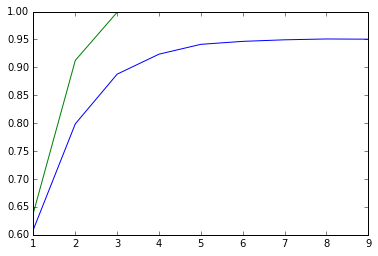

In [52]:
depths = range(1,10)


model_params['max_iterations'] = swipe_max_iterations[0]
swipe_max_depth = get_best_depth(swipes_k_fold, depths, model_factory, model_params, accuracy)

In [53]:
train_set_to_use = train_swipes
max_depth_to_use = swipe_max_depth[0]
max_iterations_to_use = swipe_max_iterations[0]

optimized_swipe_classifier = graphlab.boosted_trees_classifier.create(train_set_to_use, target='action', 
                                                                      features=features, max_depth=max_depth_to_use, 
                                                                      max_iterations=max_iterations_to_use,
                                                                      verbose=False, validation_set=None)

In [54]:
print optimized_swipe_classifier.evaluate(predicted_swipes)

{'f1_score': 0.285039048813173, 'auc': 0.9988379778928176, 'recall': 0.29888896997540465, 'precision': 0.8855138165115461, 'log_loss': 3.321085436648253, 'roc_curve': Columns:
	threshold	float
	fpr	float
	tpr	float
	p	int
	n	int
	class	int

Rows: 400004

Data:
+-----------+----------------+-----+-----+------+-------+
| threshold |      fpr       | tpr |  p  |  n   | class |
+-----------+----------------+-----+-----+------+-------+
|    0.0    |      1.0       | 1.0 | 933 | 1604 |   0   |
|   1e-05   | 0.844139650873 | 1.0 | 933 | 1604 |   0   |
|   2e-05   | 0.793640897756 | 1.0 | 933 | 1604 |   0   |
|   3e-05   | 0.756234413965 | 1.0 | 933 | 1604 |   0   |
|   4e-05   | 0.725685785536 | 1.0 | 933 | 1604 |   0   |
|   5e-05   | 0.70885286783  | 1.0 | 933 | 1604 |   0   |
|   6e-05   | 0.692019950125 | 1.0 | 933 | 1604 |   0   |
|   7e-05   | 0.673940149626 | 1.0 | 933 | 1604 |   0   |
|   8e-05   | 0.662094763092 | 1.0 | 933 | 1604 |   0   |
|   9e-05   | 0.647755610973 | 1.0 | 933 | 

# Let's go with touch classifier

In [55]:
touches_k_fold = graphlab.cross_validation.KFold(graphlab.cross_validation.shuffle(train_touchs), 5)

At iterations: 5 0.335628627118 0.346659363793
At iterations: 10 0.356594243596 0.370716639625
At iterations: 20 0.373023966053 0.390940327625
At iterations: 40 0.409167715877 0.437450863995
At iterations: 80 0.444688179463 0.480284666689
At iterations: 160 0.481927513303 0.533015248192
At iterations: 320 0.519479713832 0.587544851
At iterations: 640 0.553589646645 0.646182044786


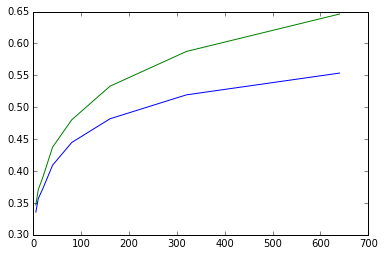

In [56]:
model_params = {'target': 'action', 'features': features, 'verbose': False, 'validation_set': None, 'max_depth': 1}
model_factory = graphlab.boosted_trees_classifier.create
touch_max_iterations = get_best_max_iterations(touches_k_fold, max_iterations_a, model_factory, model_params, accuracy)

At depth: 1 0.553589646645 0.646182044786
At depth: 2 0.810355679381 0.987834486765
At depth: 3 0.88342773171 1.0
At depth: 4 0.90408084857 1.0
At depth: 5 0.915816347132 1.0
At depth: 6 0.917694893189 1.0
At depth: 7 0.91847626459 1.0
At depth: 8 0.921293165998 1.0
At depth: 9 0.918633126183 1.0


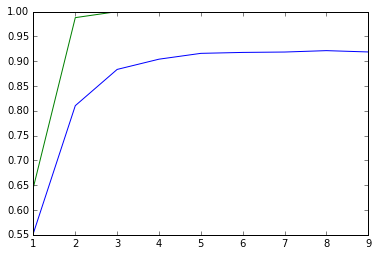

In [57]:
depths = range(1,10)
model_params['max_iterations'] = touch_max_iterations[0]
touch_max_depth = get_best_depth(touches_k_fold, depths, model_factory, model_params, accuracy)

In [58]:
train_set_to_use = train_touchs
max_depth_to_use = touch_max_depth[0]
max_iterations_to_use = touch_max_iterations[0]

optimized_touch_classifier = graphlab.boosted_trees_classifier.create(train_set_to_use, target='action', 
                                                                      features=features, max_depth=max_depth_to_use, 
                                                                      max_iterations=max_iterations_to_use,
                                                                      verbose=False, validation_set=None)

In [59]:
print optimized_touch_classifier.evaluate(predicted_touches)

{'f1_score': 0.5511537967729049, 'auc': 0.9980917989750687, 'recall': 0.601676567073975, 'precision': 0.7921691674181957, 'log_loss': 6.053149058282335, 'roc_curve': Columns:
	threshold	float
	fpr	float
	tpr	float
	p	int
	n	int
	class	int

Rows: 900009

Data:
+-----------+----------------+-----+-----+------+-------+
| threshold |      fpr       | tpr |  p  |  n   | class |
+-----------+----------------+-----+-----+------+-------+
|    0.0    |      1.0       | 1.0 | 337 | 1149 |   0   |
|   1e-05   | 0.845953002611 | 1.0 | 337 | 1149 |   0   |
|   2e-05   | 0.774586597041 | 1.0 | 337 | 1149 |   0   |
|   3e-05   | 0.728459530026 | 1.0 | 337 | 1149 |   0   |
|   4e-05   | 0.698868581375 | 1.0 | 337 | 1149 |   0   |
|   5e-05   | 0.675369886858 | 1.0 | 337 | 1149 |   0   |
|   6e-05   | 0.653611836379 | 1.0 | 337 | 1149 |   0   |
|   7e-05   | 0.641427328111 | 1.0 | 337 | 1149 |   0   |
|   8e-05   | 0.626631853786 | 1.0 | 337 | 1149 |   0   |
|   9e-05   | 0.609225413403 | 1.0 | 337 | 1

In [60]:
optimized_noise_classifier.save("noise_model")
optimized_type_classifier.save("type_model")
optimized_swipe_classifier.save("swipe_model")
optimized_touch_classifier.save("touch_model")